In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
# from tensorflow.keras.layers.core import *
# from tensorflow.keras.layers.convolutional import *
from tensorflow.keras import backend as K
import tensorflow.compat.v1 as tf

# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [40]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 21 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.coarse = 27 # the number of classes
        self.feat_d = 210 # n(n-1)/2
        self.filters = 32
        self.data_dir = '..\\data\\JESTER\\'
C = Config()

# Building the model

In [41]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H,W],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l,joint_n,joint_d):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,joint_n*joint_d))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),joint_n*joint_d))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l,joint_n,joint_d)

    print("slow", diff_slow)
    print("fast", diff_fast)
    print("JCD", M)

    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)

    # 测试删去x_d_fast
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast]) # x = concatenate([x,x_d_slow,x_d_fast])
    print('concat', x.shape)
    x = block(x,filters*2)
    print('conv1', x.shape)
    x = MaxPool1D(2)(x)
    print('pool1', x.shape)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    print('conv2', x.shape)
    x = MaxPool1D(2)(x)
    print('pool2', x.shape)    
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    print('conv3', x.shape)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [42]:
def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    print('pool', x.shape)    

    x = d1D(x,128)
    print('dense1', x.shape)    

    x = Dropout(0.5)(x)
    x = d1D(x,128)
    print('dense2', x.shape)    

    x = Dropout(0.3)(x)
    x = Dense(clc_num, activation='softmax')(x)
    print('dense3', x.shape)    

    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [43]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.coarse,C.filters)

slow Tensor("reshape_4/Identity:0", shape=(None, 32, 42), dtype=float32)
fast Tensor("reshape_5/Identity:0", shape=(None, 16, 42), dtype=float32)
JCD Tensor("input_5:0", shape=(None, 32, 210), dtype=float32)
concat (None, 16, 96)
conv1 (None, 16, 64)
pool1 (None, 8, 64)
conv2 (None, 8, 128)
pool2 (None, 4, 128)
conv3 (None, 4, 256)
pool (None, 256)
dense1 (None, 128)
dense2 (None, 128)
dense3 (None, 27)


In [44]:
DD_Net.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  [(None, 32, 210)]    0                                            
__________________________________________________________________________________________________
P (InputLayer)                  [(None, 32, 21, 2)]  0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 4, 256)       444800      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 256)          0           model_4[1][0]              

## load data

In [45]:
# 切换成无空帧数据
Train = pickle.load(open(C.data_dir+"train_noempty.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"valid_noempty.pkl", "rb"))

## Without frame_sampling train

In [27]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,C.joint_n,C.joint_d])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range_2d(p)
    
    label = np.zeros(C.coarse)
    label[Train['label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

100%|█████████████████████████████████████████████████████████████████████████████| 1234/1234 [00:09<00:00, 127.16it/s]


In [28]:
print(X_0.shape, X_1.shape, Y.shape)

(1234, 32, 210) (1234, 32, 21, 2) (1234, 27)


In [32]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,C.joint_n,C.joint_d])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range_2d(p)
    
    label = np.zeros(C.coarse)
    label[Test['label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 81.84it/s]


In [33]:
print(X_test_0.shape, X_test_1.shape, Y_test.shape)

(139, 32, 210) (139, 32, 21, 2) (139, 27)


In [48]:
import tensorflow.keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=Adam(lr),metrics=['accuracy'])
lrScheduler = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=200,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Train on 1234 samples, validate on 139 samples
Epoch 1/200
1234/1234 [==============================] - 12s 9ms/sample - loss: 1.6253 - accuracy: 0.5316 - val_loss: 2.7896 - val_accuracy: 0.2374
Epoch 2/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 1.6828 - accuracy: 0.5162 - val_loss: 2.7119 - val_accuracy: 0.2662
Epoch 3/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 1.6121 - accuracy: 0.5332 - val_loss: 2.7174 - val_accuracy: 0.2590
Epoch 4/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 1.6318 - accuracy: 0.5235 - val_loss: 2.7304 - val_accuracy: 0.2590
Epoch 5/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 1.5701 - accuracy: 0.5389 - val_loss: 2.7241 - val_accuracy: 0.2374
Epoch 6/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 1.5782 - accuracy: 0.5308 - val_loss: 2.6841 - val_accuracy: 0.2518
Epoch 7/200
1234/1234 [==============================] - 2s 1ms/sample

1234/1234 [==============================] - 2s 1ms/sample - loss: 0.7040 - accuracy: 0.8128 - val_loss: 2.7373 - val_accuracy: 0.2518
Epoch 57/200
1234/1234 [==============================] - 2s 2ms/sample - loss: 0.6739 - accuracy: 0.8323 - val_loss: 2.7464 - val_accuracy: 0.2734
Epoch 58/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 0.6882 - accuracy: 0.8088 - val_loss: 2.7479 - val_accuracy: 0.2662
Epoch 59/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 0.6857 - accuracy: 0.8169 - val_loss: 2.7249 - val_accuracy: 0.2662
Epoch 60/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 0.6719 - accuracy: 0.8225 - val_loss: 2.7118 - val_accuracy: 0.2590
Epoch 61/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 0.6585 - accuracy: 0.8290 - val_loss: 2.7086 - val_accuracy: 0.2590
Epoch 62/200
1234/1234 [==============================] - 2s 2ms/sample - loss: 0.6466 - accuracy: 0.8339 - val_loss: 2.7121 

1234/1234 [==============================] - 2s 2ms/sample - loss: 0.3187 - accuracy: 0.9198 - val_loss: 3.0913 - val_accuracy: 0.2950
Epoch 112/200
1234/1234 [==============================] - 2s 2ms/sample - loss: 0.3177 - accuracy: 0.9149 - val_loss: 3.1076 - val_accuracy: 0.2950
Epoch 113/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 0.3026 - accuracy: 0.9182 - val_loss: 3.1059 - val_accuracy: 0.2950
Epoch 114/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 0.2956 - accuracy: 0.9303 - val_loss: 3.1025 - val_accuracy: 0.2806
Epoch 115/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 0.3063 - accuracy: 0.9295 - val_loss: 3.0980 - val_accuracy: 0.2806
Epoch 116/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 0.2880 - accuracy: 0.9271 - val_loss: 3.0807 - val_accuracy: 0.3022
Epoch 117/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 0.2956 - accuracy: 0.9222 - val_loss: 3

Epoch 166/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 0.2298 - accuracy: 0.9384 - val_loss: 3.2579 - val_accuracy: 0.2950
Epoch 167/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 0.2046 - accuracy: 0.9465 - val_loss: 3.2530 - val_accuracy: 0.3022
Epoch 168/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 0.1880 - accuracy: 0.9554 - val_loss: 3.2498 - val_accuracy: 0.3022
Epoch 169/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 0.2119 - accuracy: 0.9498 - val_loss: 3.2486 - val_accuracy: 0.3022
Epoch 170/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 0.2017 - accuracy: 0.9554 - val_loss: 3.2472 - val_accuracy: 0.3022
Epoch 171/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 0.1972 - accuracy: 0.9554 - val_loss: 3.2463 - val_accuracy: 0.3022
Epoch 172/200
1234/1234 [==============================] - 2s 1ms/sample - loss: 0.1943 - accuracy: 0.9546

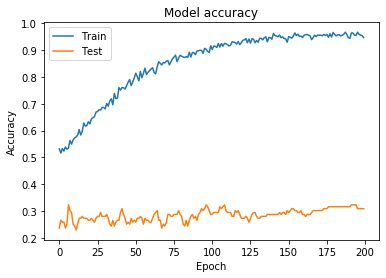

In [49]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
DD_Net.save_weights('weights/coarse_lite.h5')

## With frame_sampling

In [ ]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])

In [ ]:
epochs = 20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 

        label = np.zeros(C.clc_coarse)
        label[Train['coarse_label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,22,3])
        p = sampling_frame(p,C)
        
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )



# Calculate time (excute it twice, the first time initialize takes extra times)

In [ ]:
import time
start_time = time.time()
y = DD_Net.predict([X_0,X_1])
time.time() - start_time

# Plot confusion matrix

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = DD_Net.predict([X_test_0,X_test_1])
cnf_matrix = confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
plt.figure(figsize=(10,10))
plt.imshow(cnf_matrix)
plt.show()